In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
from random import choice

from numpy.random import default_rng

# Generate Fake Data

In [3]:
N_ROWS = 100_000

In [4]:
rng = default_rng()

In [5]:
# Make random labels
y = rng.integers(2, size=N_ROWS)

In [6]:
# Make some random numeric features
x1 = rng.normal(loc=y)
x2 = rng.normal(loc=y + x1)
x3 = rng.normal(x1)
x4 = rng.normal(x2)

In [7]:
# Make some random categoricals
pos_colors = [
    "red",
    "red",
    "orange",
    "orange",
    "yellow",
    "yellow",
    "green",
    "blue",
    "white",
    "black",
]

neg_colors = [
    "red",
    "orange",
    "yellow",
    "green",
    "green",
    "blue",
    "blue",
    "purple",
    "purple",
    "white",
    "black",
]

# Probably can do this without a loop...
cat1 = []
for label in y:
    if label == 1:
        cat1.append(choice(pos_colors))
    else:
        cat1.append(choice(neg_colors))


# And an ordered list
size = ["x-small", "small", "medium", "large", "x-large"]

size_i = np.add(rng.integers(4, size=len(y)), y)

cat2 = np.take(size, size_i)

In [8]:
# Put it into a nice dataframe
df = pd.DataFrame(
    data={
        "y": y,
        "x1": x1,
        "x2": x2,
        "x3": x3,
        "x4": x4,
        "cat1": cat1,
        "cat2": cat2,
    }
)

In [9]:
# Randomly drop some values
for col in df.columns:
    # But not the labels
    if col == "y":
        continue

    # And also not our ordinal so we don't have to worry about filling it
    if col == "cat2":
        continue

    mask = rng.choice([0, 1], p=[0.9, 0.1], size=len(df[col])).astype(bool)
    df.loc[mask, col] = np.nan

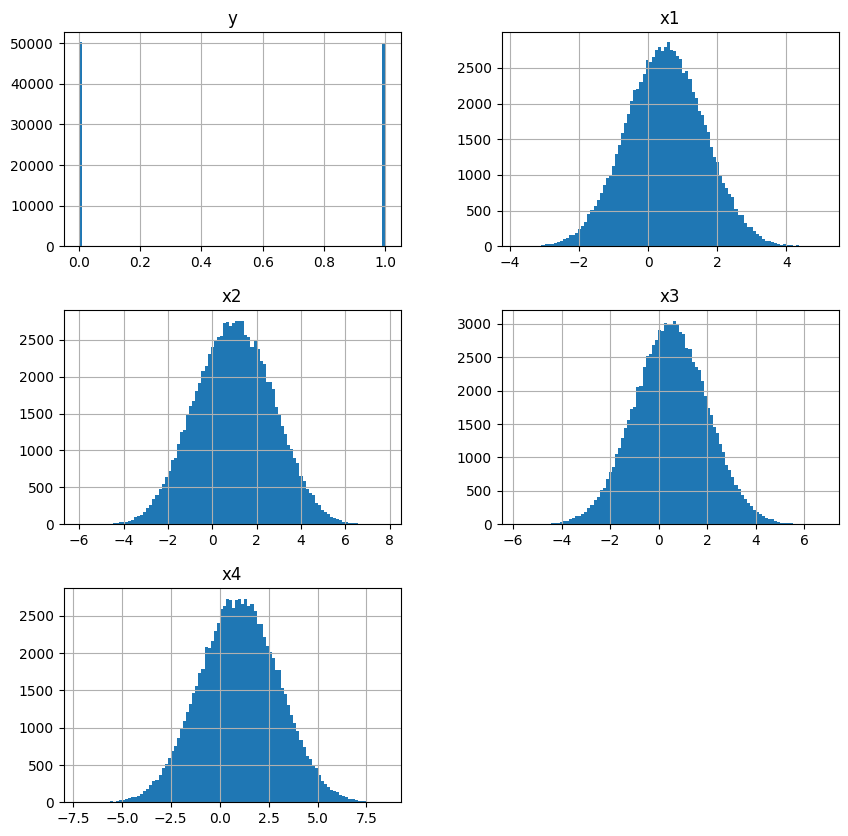

In [10]:
_ = df.hist(bins=100, figsize=(10, 10))

# Pandas Pipelines

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [12]:
# We need to define a pipeline for each group of columns we which to apply a set of transforms to

numeric_pipeline = Pipeline(
    steps=[
        ("impute_missing", SimpleImputer(strategy="median")),
        ("standard_scale", StandardScaler()),
    ]
)

unordered_categories_pipeline = Pipeline(
    steps=[
        ("one-hot_encode ", OneHotEncoder(sparse_output=False)),
    ]
)

ordered_categories_pipeline = Pipeline(
    steps=[
        ("size_encoder", OrdinalEncoder(categories=[size])),
    ]
)

In [13]:
# Then we use ColumnTransformer to assign each pipeline to a set of columns
logistic_step_name = "logistic_regression"

final_pipeline = Pipeline(
    steps=[
        (
            "feature_processing",
            ColumnTransformer(
                transformers=[
                    ("numeric_pipeline", numeric_pipeline, ["x1", "x2", "x3", "x4"]),
                    (
                        "unordered_categories_pipeline",
                        unordered_categories_pipeline,
                        ["cat1"],
                    ),
                    (
                        "ordered_categories_pipeline",
                        ordered_categories_pipeline,
                        ["cat2"],
                    ),
                ],
                remainder="passthrough",
            ),
        ),
        (
            "pca",
            ColumnTransformer(
                transformers=[
                    (
                        "pca",
                        PCA(n_components=2),
                        [
                            "numeric_pipeline__x1",
                            "numeric_pipeline__x2",
                            "numeric_pipeline__x3",
                        ],
                    )
                ],
                remainder="passthrough",
            ),
        ),
        (
            logistic_step_name,
            LogisticRegression(
                penalty="l2",
                class_weight="balanced",
                solver="saga",
                random_state=1337,
                max_iter=1_000,
            ),
        ),
    ],
)

final_pipeline.set_output(transform="pandas")

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard_scale',
                                                                   StandardScaler())]),
                                                  ['x1', 'x2', 'x3', 'x4']),
                                                 ('unordered_categories_pipeline',
                                                  Pipeline(steps=[('one-hot_encode ',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['...
                                                                   OrdinalEncoder(categories=[['x-small',
                                                                                               'small',
                                                                                               'medium',
                                                                                               'large',
                                                                                               'x-large']]))]),
                                                  ['cat2'])])),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=2),
                                                  ['numeric_pipeline__x1',
                                                   'numeric_pipeline__x2',
                                                   'numeric_pipeline__x3'])])),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=1337, solver='saga'))])

In [14]:
y = df["y"]
x = df.drop("y", axis="columns")

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1337, stratify=y
)

final_pipeline.fit(x_train, y_train)

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard_scale',
                                                                   StandardScaler())]),
                                                  ['x1', 'x2', 'x3', 'x4']),
                                                 ('unordered_categories_pipeline',
                                                  Pipeline(steps=[('one-hot_encode ',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['...
                                                                   OrdinalEncoder(categories=[['x-small',
                                                                                               'small',
                                                                                               'medium',
                                                                                               'large',
                                                                                               'x-large']]))]),
                                                  ['cat2'])])),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=2),
                                                  ['numeric_pipeline__x1',
                                                   'numeric_pipeline__x2',
                                                   'numeric_pipeline__x3'])])),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=1337, solver='saga'))])

In [15]:
# And let's search different regularization strengths
param_grid = {
    f"{logistic_step_name}__C": np.logspace(-4, 4, 4),
}

search = GridSearchCV(final_pipeline, param_grid, n_jobs=-1, scoring="precision")

search.fit(X=x_train, y=y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.812):
{'logistic_regression__C': 0.046415888336127774}


In [16]:
search.score(x_train, y_train), search.score(x_test, y_test)

(0.8119746350095856, 0.810623104763768)

In [17]:
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
)

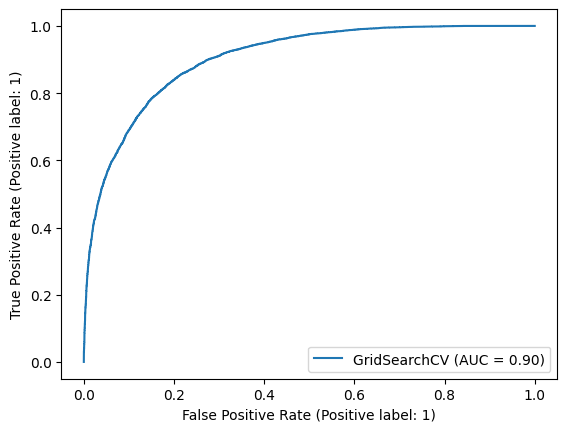

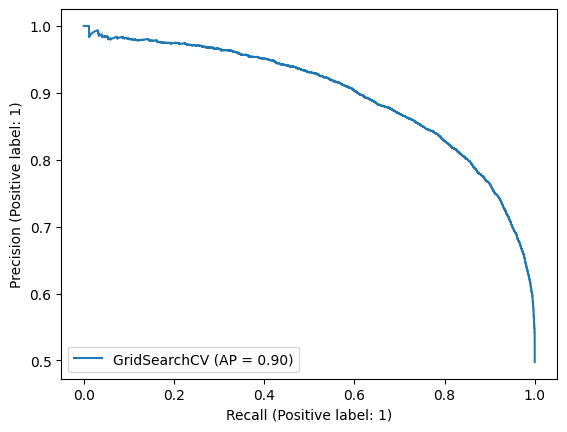

In [18]:
RocCurveDisplay.from_estimator(
    estimator=search,
    X=x_test,
    y=y_test,
)

PrecisionRecallDisplay.from_estimator(
    estimator=search,
    X=x_test,
    y=y_test,
)